<h1><center>Сборный проект. Анализ бизнес показателей. Принятие решений на основе А/В тестов </center></h1>

# Введение

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.
Создание двух групп A вместо одной поможет в случае, если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также поможет понять, сколько времени и данных потребуется для дальнейших тестов.

План работы:
- [Загрузим данные](#1) и [проведём их предобработку](#1.2);
- [Проведём исследовательский анализ данных](#2);
    - [Проанализируем количество событий по пользователям](#2);
    - [Проанализируем доступный для изучения период](#2.2);
- [Определим воронку продаж](#3) и [проанализируем её](#3.2);
- [Проведём А/А/В тест](#4);
- [Сделаем вывод.](#5)

<a id=1></a>

## Загрузка данных и подготовка их к анализу

### Зарузка данных

Загрузим необходимые библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as st
import numpy as np
import math as mth

Загрузим данные

In [4]:
data = pd.read_csv('C:/Users/RA/Documents/practicum/Portfolio/datasets/logs_exp.csv', sep='\t', )

In [5]:
pd.set_option('display.max.columns', None)
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248

Получена таблица с четырьмя столбцами и 244126 строками, где
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
Пропуски в данных отсутствуют.

<a id=1.2 ></a>

### Предобработка данных

Приведём названия столбов к змеиному стилю и переименуем некоторые столбцы

In [4]:
data.columns = ['event_name', 'device_id', 'event_unix_time', 'group']

Проверим наличие неявных дубликатов

In [5]:
display(data['event_name'].unique())
display(data['group'].unique())

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

array([246, 248, 247], dtype=int64)

Неявных дубликатов не обнаружено

Проверим наличие явных дубликатов.

In [6]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 413


Удалим явные дубликаты

In [7]:
display(data.shape)
data = data.drop_duplicates()

(244126, 4)

Проверим наличие явных дубликатов по ключевым столбцам

In [8]:
data.duplicated(subset=['event_unix_time','device_id', 'event_name']).sum()

0

Дубликатов по ключевым столбцам не обнаружено

Проверим, всем ли пользователям соответствуют только одна группа

In [9]:
data.pivot_table(index='device_id', values='group', aggfunc='nunique').query('group > 1')

Empty DataFrame
Columns: [group]
Index: []

Все пользователи разделены на группы верно, нескольких групп для одного пользователя не обнаружено.

Переименуем названия групп для удобстава:
 - А1 - контрольная группа 246;
 - А2 - контротльная группа 247;
 - B - экспериментальная нруппа 248.

In [10]:
def rename_group(group):
    try:
        if group == 246:
            return 'A1'
        elif group == 247:
            return 'A2'
        elif group == 248:
            return 'B'
    except:
        pass
data['group'] = data['group'].apply(rename_group)

Добавим к таблице столбцы с датой и временем и датой

In [11]:
data['event_datetime'] = pd.to_datetime(data['event_unix_time'], unit='s')
data['event_date'] = pd.to_datetime(data['event_datetime']).dt.date
data.head()

event_name            device_id  event_unix_time group  \
0         MainScreenAppear  4575588528974610257       1564029816    A1   
1         MainScreenAppear  7416695313311560658       1564053102    A1   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     B   
3         CartScreenAppear  3518123091307005509       1564054127     B   
4  PaymentScreenSuccessful  6217807653094995999       1564055322     B   

       event_datetime  event_date  
0 2019-07-25 04:43:36  2019-07-25  
1 2019-07-25 11:11:42  2019-07-25  
2 2019-07-25 11:28:47  2019-07-25  
3 2019-07-25 11:28:47  2019-07-25  
4 2019-07-25 11:48:42  2019-07-25

Проверим наличие аномальных значений дат

In [12]:
data['event_date'].value_counts().to_frame().sort_index()

event_date
2019-07-25           9
2019-07-26          31
2019-07-27          55
2019-07-28         105
2019-07-29         184
2019-07-30         412
2019-07-31        2030
2019-08-01       36141
2019-08-02       35554
2019-08-03       33282
2019-08-04       32968
2019-08-05       36058
2019-08-06       35788
2019-08-07       31096

Данные представлены за 14 дней в период с 25 июля по 7 августа 2019 года. Аномальные значени отсутствуют. В первые 7 дней, в период с 25 по 31 июля, наблюдается оносительно малое количество  уникальных событий по сравнению с последующими датами. В следующей части проекта рассмотрим такое распределение событий по датам более подробно.

<a id=2 ></a>

## Исследовательский анализ данных

### Анализ количества событий по пользователям

In [13]:
print('В логе предствалено ', data.shape[0], 'события.')
print('Количество уникальных пользователей:', data['device_id'].nunique())

В логе предствалено  243713 события.
Количество уникальных пользователей: 7551


Рассмотрим сколько в среднем событий приходится на одного пользователя

In [14]:
event_per_user = data.groupby('device_id')['event_name'].count().to_frame()
print('Среднее количество событий на одного пользователя:', round(event_per_user.mean(), 1))
print('Медианное количество событий на одного пользователя:', round(event_per_user.median(), 1))

Среднее количество событий на одного пользователя: event_name    32.3
dtype: float64
Медианное количество событий на одного пользователя: event_name    20.0
dtype: float64


In [15]:
round(event_per_user.describe(), 1)

event_name
count      7551.0
mean         32.3
std          65.2
min           1.0
25%           9.0
50%          20.0
75%          37.0
max        2307.0

Построим BoxPlot

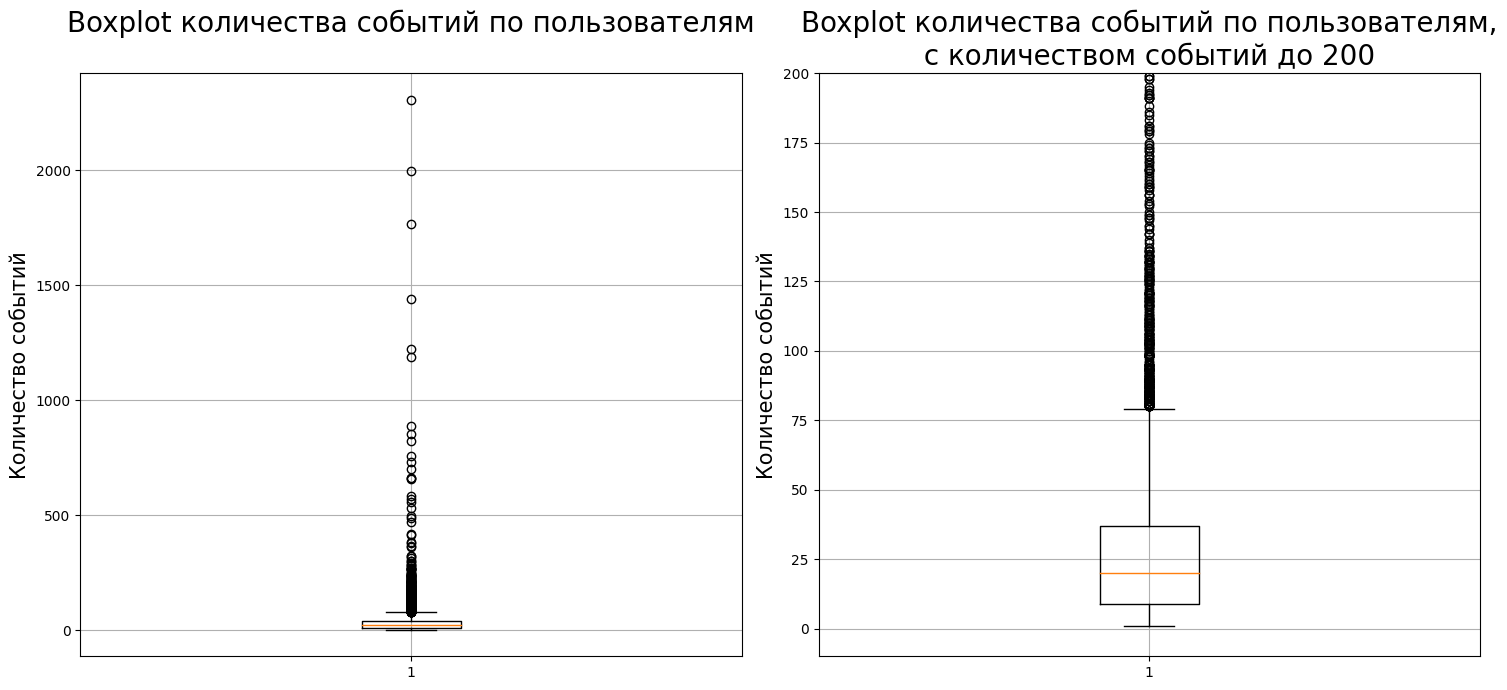

In [16]:
plt.figure(figsize=(15, 7))

ax1 = plt.subplot(1,2,1)
plt.boxplot(
    event_per_user
)
plt.grid(True)
plt.title('Boxplot количества событий по пользователям\n', fontsize=20)
plt.ylabel('Количество событий', fontsize=15)

ax2 = plt.subplot(1,2,2)
plt.boxplot(
    event_per_user
)
plt.ylim([-10, 200])
plt.grid(True)
plt.title('Boxplot количества событий по пользователям,\n с количеством событий до 200 ', fontsize=20)
plt.ylabel('Количество событий', fontsize=15)
plt.tight_layout();

<a id=percentile ></a>

Рассчитаем перцентили

In [17]:
percentile=[]
percentile_range=np.arange(90, 100, 0.5)
for i in percentile_range:
    percentile.append(round(np.percentile(event_per_user['event_name'], [i])[0], 2))
percentile_df = pd.DataFrame({'percentile_range': percentile_range, 'percentile_values': percentile})
percentile_df.T

0      1     2     3     4     5     6     7     8   \
percentile_range   90.0  90.50  91.0  91.5  92.0  92.5  93.0  93.5  94.0   
percentile_values  64.0  65.75  67.0  69.0  71.0  74.0  77.0  80.0  83.0   

                     9     10    11     12     13     14      15     16  \
percentile_range   94.5  95.0  95.5   96.0   96.5   97.0   97.50   98.0   
percentile_values  86.0  89.0  93.0  100.0  106.0  115.5  125.25  136.0   

                      17     18      19  
percentile_range    98.5   99.0   99.50  
percentile_values  165.0  200.5  270.25

В логе представлено 243713 события для 7551 уникальных пользователей. Наблюдается большое количество пользователей с аномальным количеством уникальных событий. Около 7% пользователей, по количеству уникальных событий, выходят за рамки полутора межквартальных размахов.

<a id=2.2 ></a>

### Анализ доступного для изучения периода

Ранее мы выяснили, что данные представлены за период за 14 дней. В первую половину периода, с 25 июля по 7 августа 2019 года,  наблюдается оносительно малое количество  уникальных событий по сравнению со второй половиной. Рассмотрим как меняется количество данных в зависимости от времени в разрезе групп. А также количество уникальных пользователе по дням в разрезе групп

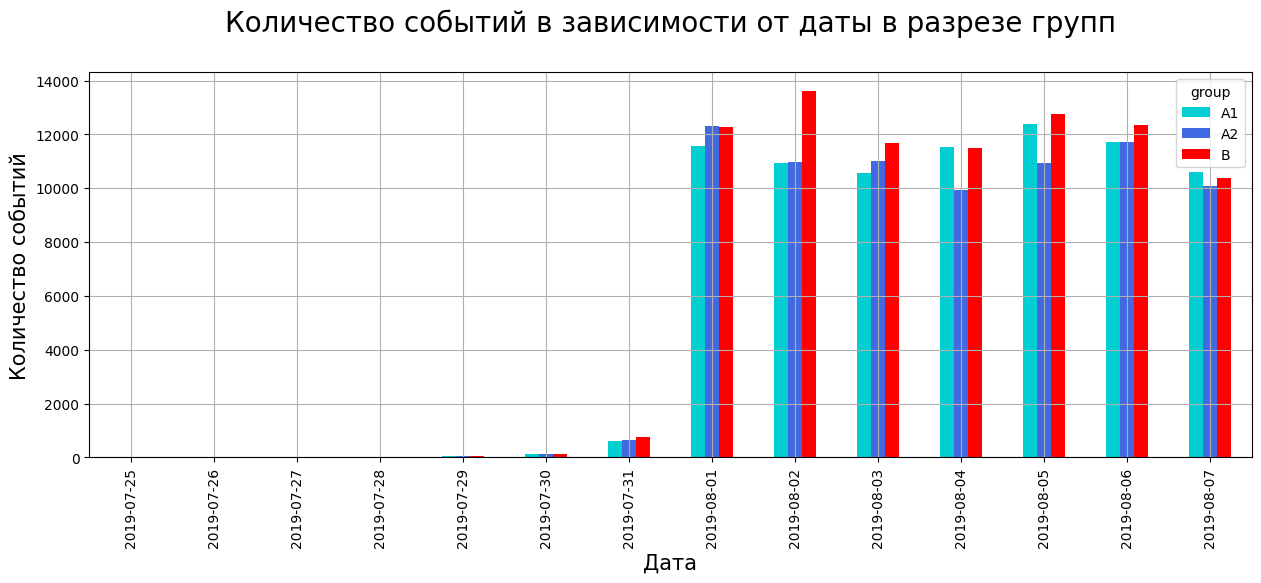

In [18]:
data.pivot_table(index='event_date', columns='group', values='event_name', aggfunc='count').plot(
    kind='bar',
    figsize=(15, 5),
    grid=True,
    color=['DarkTurquoise', 'royalblue', 'red']
)
plt.title('Количество событий в зависимости от даты в разрезе групп\n', fontsize=20)
plt.ylabel('Количество событий', fontsize=15)
plt.xlabel('Дата', fontsize=15);

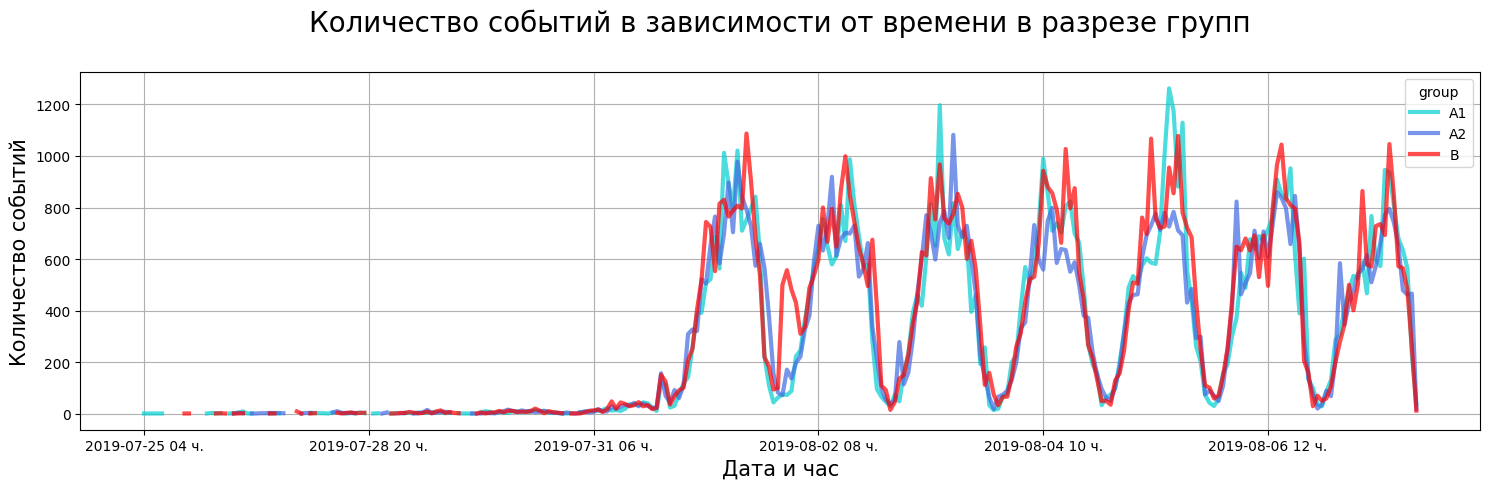

In [19]:
data.pivot_table(index=(data['event_datetime'].dt.strftime('%Y-%m-%d %H ч.')),
                 columns='group', values='event_name', aggfunc='count').plot(
    grid=True,
    figsize=(15, 5),
    color=['DarkTurquoise', 'royalblue', 'red'],
    linewidth=3,
    alpha=0.7
);
plt.title('Количество событий в зависимости от времени в разрезе групп\n', fontsize=20)
plt.ylabel('Количество событий', fontsize=15)
plt.xlabel('Дата и час', fontsize=15)
plt.tight_layout();

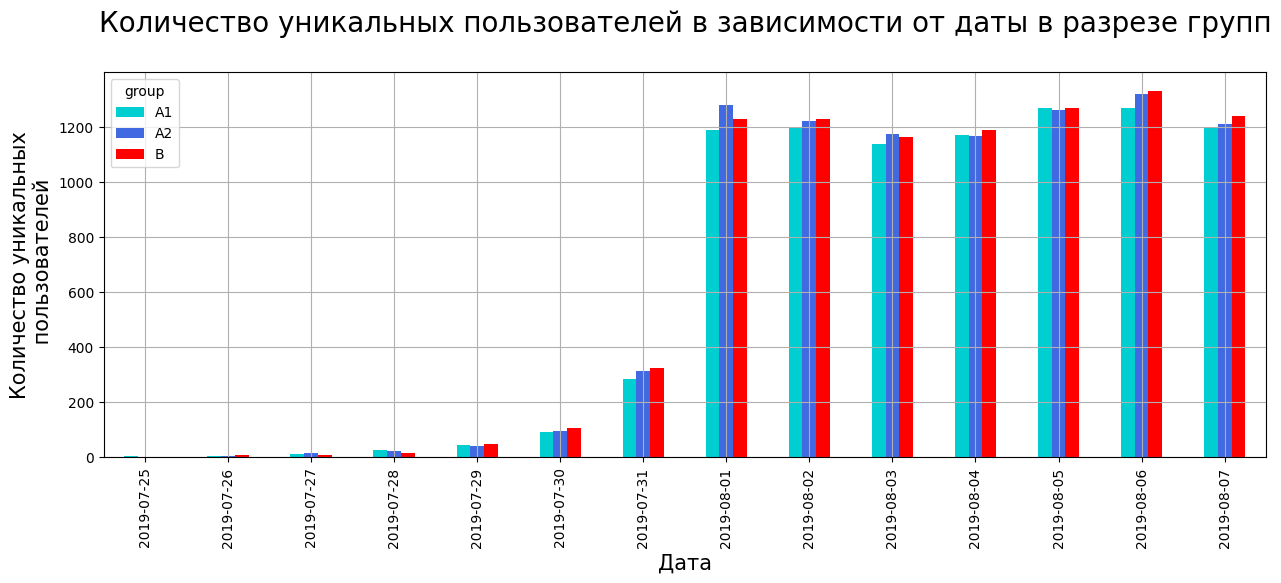

In [20]:
data.pivot_table(index='event_date', columns='group', values='device_id', aggfunc='nunique').plot(
    kind='bar',
    figsize=(15, 5),
    grid=True,
    color=['DarkTurquoise', 'royalblue', 'red']
)
plt.title('Количество уникальных пользователей в зависимости от даты в разрезе групп\n', fontsize=20)
plt.ylabel('Количество уникальных\n пользователей', fontsize=15)
plt.xlabel('Дата', fontsize=15);

По графикам видно, что распределение количества уникальных событий между группами сопоставимо. Но в первые 7 дней наблюдается кратно меньшее количество событий. В ночные часы в августе, когда наблюдается наименьшеее количество событий, их больше чем в люоме время суток в июле. Рапсределение уникальных пользователей между группами по дням коррелируем между собой. Из чего можно сделать вывод, что распределение трафика на группы произошло успешно. Можно сказать, что полные репрезентативные данные начинаются лишь с 1 августа 2019 года. Данные за июль можно отнести к ошибкам логирования. Удалим их из датафрейма

In [21]:
df = data.loc[data['event_datetime'] >= '2019-08-01']

In [22]:
print('Изначальное количество событий - ', len(data),
      'после фильтрации -', len(df),
      'итого удалено', round((1 - len(df) / len(data))* 100, 1), '% данных.')
print('Изначальное количество уникальных пользователей - ', data['device_id'].nunique(),
      'после фильтрации -',  df['device_id'].nunique(),
      'итого удалено', round(data['device_id'].nunique() - df['device_id'].nunique(), 1), 'пользователей.')

Изначальное количество событий -  243713 после фильтрации - 240887 итого удалено 1.2 % данных.
Изначальное количество уникальных пользователей -  7551 после фильтрации - 7534 итого удалено 17 пользователей.


После фильтрации было удалено лишь 1.2% даннных, всего по 17 пользователям, что приемлимо для последующего анализа данных.

<a id=3 ></a>

## Воронка событий

### Определение воронки продаж

Рассмотри подробнее типы событий прдставлеенных в логах.

In [23]:
events_count = pd.crosstab(df['event_date'], df['event_name'], margins=True)
events_count[events_count.loc['All'].sort_values(ascending=False).index].style.background_gradient(axis=1)

В логах представлено пять событий, далее они представлены по уменьшению их количетсва:
- `MainScreenAppear` - Появление главного экрана, 117328 события;
- `OffersScreenAppear` - Появление экрана предложения, 46633 события;
- `CartScreenAppear` - Появление экрана корзины, 42303 события;
- `PaymentScreenSuccessful` - Появление экрана успешной оплаты, 33918 события;
- `Tutorial` - Прохождение обученияб, 1005 событий.

Как видим обучение проходит минимальное количество пользователей, всего 1005 событий из 240887, что составляет всего 0.4% Такое низкое значение можно объяснить и тем, что прохождение обучения, как правило, единоразовое событие для конкретного пользователя, остальные же события могут происходит неоднократно. Распределение долей каждого события по дням, примерно одинаково. Можно предположить, что оставшиеся события составляют воронку продаж: главный экран - экран предложения - корзина - оплата

In [24]:
users_per_events = pd.crosstab(df['event_date'], df['event_name'], values=df['device_id'], aggfunc='nunique', margins=True)
users_per_events = users_per_events[users_per_events.loc['All'].sort_values(ascending=False).index]
users_per_events.style.background_gradient(axis=1)

In [25]:
round(users_per_events[-1:].apply(lambda x: x/x.max()*100, axis=1), 1)

event_name    All  MainScreenAppear  OffersScreenAppear  CartScreenAppear  \
event_date                                                                  
All         100.0              98.5                61.0              49.6   

event_name  PaymentScreenSuccessful  Tutorial  
event_date                                     
All                            47.0      11.1

Предполагаемая ранее воронка продаж ещё более отчетливо прослеживается по таблице основаной на количестве уникальных пользователей по событиям. 47% уникальных пользователей совершало когда-либо оплату. Исключим из воронки продаж событие `Tutorial`, т.к. лишь малый процент пользователей (11%) проходит обучение и как говорилось ранее это, как правило, одноразовое событие не требуюшимся при совершении покупок в приложении. Итоговая воронка продаж модет виглядять как:
- 1) `MainScreenAppear` - Появление главного экрана;
- 2) `OffersScreenAppear` - Появление экрана предложения;
- 3) `CartScreenAppear` - Появление экрана корзины;
- 4) `PaymentScreenSuccessful` - Появление экрана успешной оплаты;

In [26]:
df_worksheet = df.query('event_name != "Tutorial"')

#### Анализ пользователей с аномальным количеством событий

Рассмотрим некоторых пользователей с аномольным количеством событий больше [98.5 перцентиля](#percentile)

In [27]:
list_abnormal_id = event_per_user.reset_index().query('event_name > 165.5')['device_id']
df_abnormal_id = df.query('device_id in @list_abnormal_id')
users_per_events_abnormal = pd.crosstab(df_abnormal_id['event_date'], df_abnormal_id['event_name'], margins=True)
users_per_events_abnormal = users_per_events_abnormal[users_per_events_abnormal.loc['All'].sort_values(ascending=False).index]
users_per_events_abnormal.style.background_gradient(axis=1)

In [28]:
(df.query('device_id in @list_abnormal_id')
   .pivot_table(index='group', columns='event_name', values='event_date', aggfunc='count')
   .style.background_gradient(axis=1).format('{:.0f}'))

Распределение количества событий по типам не сооответсвует вышеуказанной воронке продаж. Заметных различий между распределеним типов событий по дням нет. Наблюдается аномально большое количество событий показа экрана корзины и успешной оплаты при аномально низком количестве показов главного экрана и экрана предложения. Распределение типов событий по группам пропорционально, но их количество в по группа разное. Нименьшее влияние "аномальные" пользователи оказыввают на группу A2. Такие данные могли возникнуть из-за ошибок в логировании событий. Рассмоторим какую долю событий занимают эти пользователи из общего числа. Примем за аномальные значения выше 98.5 перцентиля.

In [29]:
list_id = event_per_user.reset_index().query('event_name < 165.5')['device_id']
df2 = df.query('device_id in @list_id')
print('При использовании 98.5% перцентиля количества событий по пользователям, в логе останется',
      round(len(df2)/len(df) * 100, 1), '% событий. При этом будут удалены лишь данные по ',
      df['device_id'].nunique() - len(list_id), 'пользователям, что составляет',
      round((1-len(list_id)/df['device_id'].nunique())*100, 1), '%.')
events_count2 = pd.crosstab(df2['event_date'], df2['event_name'], margins=True)
display(events_count2[events_count2.loc['All'].sort_values(ascending=False).index].style.background_gradient(axis=1))
users_per_events2 = pd.crosstab(df2['event_date'], df2['event_name'], values=df2['device_id'], aggfunc='nunique', margins=True)
users_per_events2 = users_per_events2[users_per_events2.loc['All'].sort_values(ascending=False).index]
users_per_events2.style.background_gradient(axis=1)

При использовании 98.5% перцентиля количества событий по пользователям, в логе останется 83.1 % событий. При этом будут удалены лишь данные по  95 пользователям, что составляет 1.3 %.


Разница между в количестве событий по типу по дням после удаления "аномальных" пользователей

In [30]:
display(events_count2 - events_count)

event_name  CartScreenAppear  MainScreenAppear  OffersScreenAppear  \
event_date                                                           
2019-08-01             -2142              -749               -1137   
2019-08-02             -2432              -914               -1113   
2019-08-03             -2178              -903                -961   
2019-08-04             -2093              -790               -1001   
2019-08-05             -2384              -985               -1028   
2019-08-06             -1832              -890                -930   
2019-08-07             -1623              -767                -783   
All                   -14684             -5998               -6953   

event_name  PaymentScreenSuccessful  Tutorial    All  
event_date                                            
2019-08-01                    -1893        -6  -5927  
2019-08-02                    -2176        -9  -6644  
2019-08-03                    -1962        -3  -6007  
2019-08-04                    -1879        -5  -5768  
2019-08-05                    -2069        -5  -6471  
2019-08-06                    -1614        -7  -5273  
2019-08-07                    -1472         0  -4645  
All                          -13065       -35 -40735

При использовании 98.5 перцентиля из лога будут удалены всего 95 пользователей, но количество событий уменьшится на 16.9%, что неприемлимо для дальнейшего анализа. Наибольшие изменения коснуться событий показа корзины и экрана успешной покупки. Тем не менее распределение количества событий по типу останется практически таким же. Оставим данные без изменений списав их на ошибки логирования.

<a id=3.2 ></a>

### Анализ воронки продаж

Расчитаем воронки продаж для уникальных пользователей `df_sales_funnel_unique` и без учёта уникальных пользователей `df_sales_funnel` и доли пользователей проходящих на следующий шаг воронки (от числа пользователей на предыдущем).

In [31]:
df_sales_funnel_unique = (pd.crosstab(df_worksheet['event_name'], df_worksheet['group'],
                                      values=df_worksheet['device_id'], aggfunc='nunique',margins=True)
            [:-1] #Избавляемся от строки 'All'
            .sort_values(by='A1', ascending=False)
                
)
df_sales_funnel = (pd.crosstab(df_worksheet['event_name'], df_worksheet['group'],
                               values=df_worksheet['device_id'], aggfunc='count',margins=True)
            [:-1] #Избавляемся от строки 'All'
            .sort_values(by='A1', ascending=False)
                
)
display('Воронка продаж без разделения по пользователям')
display(df_sales_funnel.style.background_gradient(axis=0),
       (df_sales_funnel.div(df_sales_funnel.shift(1)).fillna(1)).style.format('{:.1%}'))
display('Воронка продаж для уникальных пользователей')
display(df_sales_funnel_unique.style.background_gradient(axis=0),
       (df_sales_funnel_unique.div(df_sales_funnel_unique.shift(1)).fillna(1)).style.format('{:.1%}'))

'Воронка продаж без разделения по пользователям'

'Воронка продаж для уникальных пользователей'

Существенных различий в распределении количества событий и количества пользователей у которых происходили указанные типы событий во всех трёх группах нет. Доли пользователей перешедших на следующий шаг воронки между группами пратически идентичны. На первом шаге переход с главного экрана на экран предложения в среднем осуществляют 61.9% пользователей. На втором шаге переход с экрана предложения в корзину осуществляют в среднем 81.3% пользователя. И на третьем шаге оплату производит  в среднем 94.8% пользователей. Как видим, на 1 шаге теряется больге всего пользователей, 39.1% пользователе йне переходят с главного экрана на экран предложения. Переход же к оплате после экрана корзины осуществляют почти все пользователи - 94.8%. Следуя этим данным можно говорить об очень хорошем уровне конверсии. Но следует учитывать, что один пользователь заходит в приложение неоднократно, но совершает покупки не всегда, но таблица воронки продаж для уникальных пользователей показывает осуществлял ли пользователь переход на следующий шаг воронки хотя бы раз. Рассмотрим воронку продаж без разделения по уникальным пользователмя. Здесь показатели доли перехода в воронке продаж с главного экрана на экран предложения ниже и равны 39.5%, что в полтора раза ниже тот же показатель при группирове по пользователям. На втором шаге доля переходов с экрана предложения в корзину выше, и равна 91.3%. На этом шаге отмечается большой разброс в значениях между группами, в группе A2 показатель равен 81.9%, в то время как в группах A1 и В 99.5% и 92.6% соответственно. На третьем шаге воронки, покупку осуществляют в 80.2% случаем в среднем, что ниже этого показателя при группировке событий по пользователям. Как было указано выше эт следствии того, что пользователь хотя бы раз сделавший покупку совершаеет её не в каждую сессию хзвхода в приложение.

Рассчитаем долю уникальных пользователей доходящих от первого события до оплаты по группам.

In [32]:
df_worksheet = df.query('event_name != "Tutorial"')
print('Количество пользователей совершавших все 4 события из воронки продаж равно:',
      len(df_worksheet.groupby('device_id')['event_name'].nunique().to_frame().query('event_name == 4')),
      'Их доля от всех уникальных пользователей\nв количестве', len(df_worksheet.groupby('device_id')),
      'равна', round(len(df_worksheet.groupby('device_id')['event_name'].nunique().to_frame().query('event_name == 4'))
      / len(df_worksheet.groupby('device_id')) * 100, 1), '%')

Количество пользователей совершавших все 4 события из воронки продаж равно: 3429 Их доля от всех уникальных пользователей
в количестве 7530 равна 45.5 %


In [33]:
df_sales_funnel_unique_part = round(df_sales_funnel_unique.apply(lambda x: x / x.max() * 100, axis=0), 1)

In [34]:
fig = px.funnel(df_sales_funnel_unique_part, x=['A1', 'A2', 'B'], y=df_sales_funnel_unique_part.index)
fig.update_layout(title='Воронка продаж по группам', title_x = 0.5, yaxis_title='Шаг воронки продаж')
fig.show()

Доля пользователей совершавших все 4 события из воронки продаж равна 45.5%, различия между группами не существенны, наибольшая "потеря" пользователей происходит на этапе перехода с главного экрана на экран предложения. Почти все пользователи перешедшие в корзину осуществляли покупкку хотя бы раз.

<a id=4 ></a>

## A/A/B эксперимент

Посмотрим сколько пользователей в каждой из групп.

In [35]:
display(df_worksheet.groupby('group')['device_id'].nunique())

group
A1    2483
A2    2512
B     2535
Name: device_id, dtype: int64

Пользователи распределены между группам достаточно равномерно. 

Построим таблицу с данными о количестве уникальных пользователей на каждом этапе и доле пользователей передедших на следующий этап маркетинговой воронки по группам. 

In [36]:
test_table_users = (pd.crosstab(
    df_worksheet['event_name'], df_worksheet['group'], values=df_worksheet['device_id'], aggfunc='nunique', margins=True)
              .sort_values(by='A1', ascending=False))

test_table_users['A_united'] = test_table_users['A1'] + test_table_users['A2']

test_table_percent = round(test_table_users.apply(lambda x: x / x.max() * 100, axis=0), 1)\
                    .rename(columns={'A1': 'A1_percent', 'A2': 'A2_percent', 'B': 'B_percent',
                                     'All': 'All_percent', 'A_united': 'A_united_percent'})

test_table = test_table_users.join(test_table_percent).rename_axis(None, axis=1).reset_index()
test_table

event_name    A1    A2     B   All  A_united  A1_percent  \
0                      All  2483  2512  2535  7530      4995       100.0   
1         MainScreenAppear  2450  2476  2493  7419      4926        98.7   
2       OffersScreenAppear  1542  1520  1531  4593      3062        62.1   
3         CartScreenAppear  1266  1238  1230  3734      2504        51.0   
4  PaymentScreenSuccessful  1200  1158  1181  3539      2358        48.3   

   A2_percent  B_percent  All_percent  A_united_percent  
0       100.0      100.0        100.0             100.0  
1        98.6       98.3         98.5              98.6  
2        60.5       60.4         61.0              61.3  
3        49.3       48.5         49.6              50.1  
4        46.1       46.6         47.0              47.2

Проверим, находят ли статистические критерии разницу между контрольными группами А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Сравним пропорций двух генеральных совокупностей по выборкам из них. Напишем функцию, для расчётов используем данные о количестве уникальных пользователей по первому и последнему типу события в воронке продаж: `MainScreenAppear` и `PaymentScreenSuccessful`. За нулевую гипотезу принимаем равенство групп, за альтернативную ргуппы не равны. Далее проверим находят ли ститистические критерии различия между всеми представленными группами попарно. Используем значение уровня ститистической значимости `alpha` равное 0.01 т.к. изначально группы близки по значениям, то критерий для них должен быть более строгим для выявления минимальных изменений. Так как мы используем множественную проперку гипотез, то используем поправку к занчению `alpha`, воспользуемся методом Бонферрони.

In [37]:
def z_test(group1, group2, alpha):
    for i in group1.index:
        if i != 0:
            # пропорция успехов в первой группе:
            p1 = group1[i] / group1[0]
            
            # пропорция успехов во второй группе:
            p2 = group2[i] / group2[0]
            
            # пропорция успехов в комбинированном датасете:
            p_combined = ((group1[i] + group2[i]) / (group1[0] +group2[0]))
            
            # разница пропорций в датасетах
            difference = p1 - p2
            
            # считаем статистику в ст.отклонениях стандартного нормального распределения
            z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group1[0] + 1/group2[0]))
            
            # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
            distr = st.norm(0, 1) 
                                            
            p_value = (1 - distr.cdf(abs(z_value))) * 2
            
            print('Для', test_table['event_name'][i], 'p-значение равно ', p_value.round(3))

            if p_value < alpha:
                print('P-value меньше критического уровня статистической значимости равного', alpha,
                      '\nОтвергаем нулевую гипотезу: между группами есть значимая разница.\n')
            else:
                print(
                    'P-value больше критического уровня статистической значимости равного', alpha,
                    '\nНе получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.\n') 
        else:
            pass

В нашем эсперименте будет 16 тестов, 4 теста по количеству шагов в воронке продаж для 4 пар сравниваемых групп:
- `A1`/`A2`;
- `A1`/`B`;
- `A2`/`B`;
-`A_united`/`B`.

Введём поправку Бонферрони для значение `alpha`, разделив его на количество тестов (16) 

In [38]:
alpha = 0.01
alpha_corr = alpha / 16

In [39]:
print('Для изначального значения уровня стастистичсекой значимости равного', alpha,
      'групповая вероятность ошибки первого рода равна равна', round(1 - (1 - alpha)**16, 3),'.\n',
      'Для скорректированного значения уровня стастистичсекой значимости равного', alpha_corr,
      'групповая вероятность ошибки первого рода\nравна равна', round(1 - (1 - alpha_corr)**16, 3))

Для изначального значения уровня стастистичсекой значимости равного 0.01 групповая вероятность ошибки первого рода равна равна 0.149 .
 Для скорректированного значения уровня стастистичсекой значимости равного 0.000625 групповая вероятность ошибки первого рода
равна равна 0.01


После введения попраки Бонферетти вероятность ошибки первого рода при множественном сравнении гипотез уменьшилавь с 14.9% до 1%

In [40]:
z_test(test_table['A1'], test_table['A2'], alpha_corr)

Для MainScreenAppear p-значение равно  0.753
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для OffersScreenAppear p-значение равно  0.248
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для CartScreenAppear p-значение равно  0.229
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для PaymentScreenSuccessful p-значение равно  0.114
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.



In [41]:
z_test(test_table['A1'], test_table['B'], alpha_corr)

Для MainScreenAppear p-значение равно  0.339
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для OffersScreenAppear p-значение равно  0.214
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для CartScreenAppear p-значение равно  0.081
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для PaymentScreenSuccessful p-значение равно  0.217
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.



In [42]:
z_test(test_table['A2'], test_table['B'], alpha_corr)

Для MainScreenAppear p-значение равно  0.519
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для OffersScreenAppear p-значение равно  0.933
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для CartScreenAppear p-значение равно  0.588
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для PaymentScreenSuccessful p-значение равно  0.728
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.



In [43]:
z_test(test_table['A_united'], test_table['B'], alpha_corr)

Для MainScreenAppear p-значение равно  0.349
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для OffersScreenAppear p-значение равно  0.446
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для CartScreenAppear p-значение равно  0.187
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.

Для PaymentScreenSuccessful p-значение равно  0.611
P-value больше критического уровня статистической значимости равного 0.000625 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.



Различий между всеми тремя группами, при заданных уровнях статистической значимости, не обнаружено.

<a id=5 ></a>

## Вывод

Нам были предоставлены логи мобильного приложени япо продаже продуктов питания. Дизайнеры решили изменить шрифты во всём приложении. Но менеджеры отнеслись к нововведению скептически. Было решено провести A/A/B эксперимент и на основе его результатов принять решение о внедрении новых шрифтов. Пользователи были разделены на 3 группы: 2 контрольные (`A1` и `A2`) со старыми шрифтами и одну экспериментальную (`B`) — с новыми. Создание двух групп A вместо одной поможет в случае, если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. 

Была проведена предобработка данных, в частности удалены дубликаты, добавлены столбцы с датой и временем совершения события. Исходные данные были усечены с 14 до 7 дней, т.к. в первую половину исследуемого периода количество событий было кратно меньше чем во второй половине. Что могло произойти из-за ошибок логирования событий. Было выявлено большое количество пользователей с аномально большим количеством совершённых покупок при кратно меньшем количестве предшествующих ему событий. Они были оставлены в логах, т.к. при их удалении объём данных уменьшался почти на 17%, что неприемлимо. Распределение количества событий и уникальных пользователей между группами и по дням равномерно.

Была определена воронка продаж, шаги, которые пользователи совершали перед покупкой:
- 1) `MainScreenAppear` - Появление главного экрана;
- 2) `OffersScreenAppear` - Появление экрана предложения;
- 3) `CartScreenAppear` - Появление экрана корзины;
- 4) `PaymentScreenSuccessful` - Появление экрана успешной оплаты;

Шаги воронки были определены по количеству событий. Наибольшие "потери" пользователей происходят на этапе перехода с главного экрана ( `MainScreenAppear`) на экран предложения (`OffersScreenAppear`). Лишь 61.9% пользователей хотя бы раз совершали переход на этом шаге. Наибольшая доля пользователей переходящих с одного шага другой наблюдается на шаге между экраном корзины (`CartScreenAppear`) и экраном успешной оплаты (`PaymentScreenSuccessful`), 94.8% пользователей.

В ходе А/А/В эксперимента была произведено сравнение всех трёх групп между собой и объединенной контрольной группы с эспериментальной группой. Для заданного изначально уровня статистической значимости равного 0.01 была введена поправка Бонферронии на множественную проверку гипотез. В результате различий между всеми тремя группами, при заданных уровнях статистической значимости, обнаружено не было. Следовательно изменение шрифтов не сказалось на продажах. А значит новые шрифты могут быть внеднены в приложении.